In [7]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [8]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/11.png'   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 468
drwxr-xr-x 30 root root   4096 Sep 15 01:58  aiffel
drwxr-xr-x  2 root root   4096 Aug 25 03:10  data
-rw-r--r--  1 root root 468632 Sep 15 04:47 'E18. OCR.ipynb'
Texts:

"36000 29145 2
"

"36000"

"29145"

"2"
bounds: (204,133),(213,133),(213,152),(204,152)


In [9]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [10]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


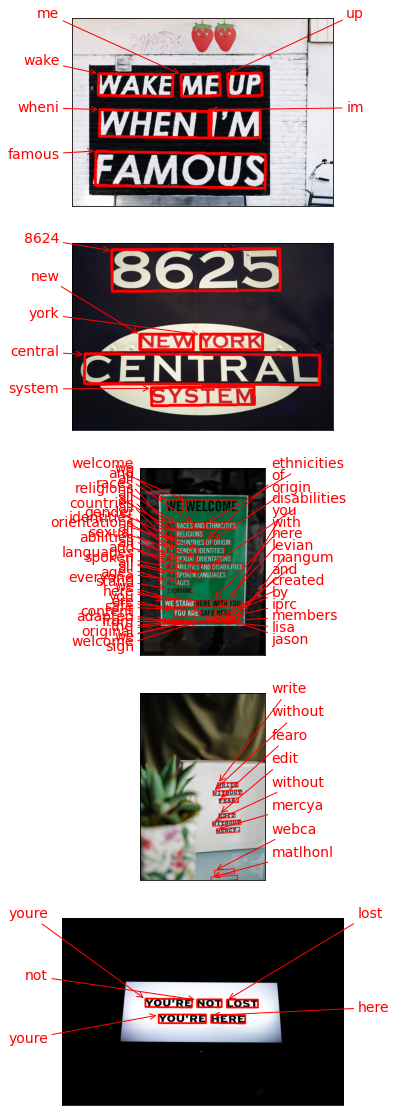

In [11]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [12]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/11.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png


In [13]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

6

2O145

56000

Done


In [14]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

In [16]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/'

images = glob(work_dir+'*.jpg')
images.sort()
images

['/aiffel/aiffel/ocr_python/q1.jpg',
 '/aiffel/aiffel/ocr_python/q10.jpg',
 '/aiffel/aiffel/ocr_python/q11.jpg',
 '/aiffel/aiffel/ocr_python/q12.jpg',
 '/aiffel/aiffel/ocr_python/q13.jpg',
 '/aiffel/aiffel/ocr_python/q14.jpg',
 '/aiffel/aiffel/ocr_python/q15.jpg',
 '/aiffel/aiffel/ocr_python/q16.jpg',
 '/aiffel/aiffel/ocr_python/q17.jpg',
 '/aiffel/aiffel/ocr_python/q18.jpg',
 '/aiffel/aiffel/ocr_python/q19.jpg',
 '/aiffel/aiffel/ocr_python/q2.jpg',
 '/aiffel/aiffel/ocr_python/q20.jpg',
 '/aiffel/aiffel/ocr_python/q3.jpg',
 '/aiffel/aiffel/ocr_python/q4.jpg',
 '/aiffel/aiffel/ocr_python/q5.jpg',
 '/aiffel/aiffel/ocr_python/q6.jpg',
 '/aiffel/aiffel/ocr_python/q7.jpg',
 '/aiffel/aiffel/ocr_python/q8.jpg',
 '/aiffel/aiffel/ocr_python/q9.jpg']

ValueError: num must be 1 <= num <= 18, not 19

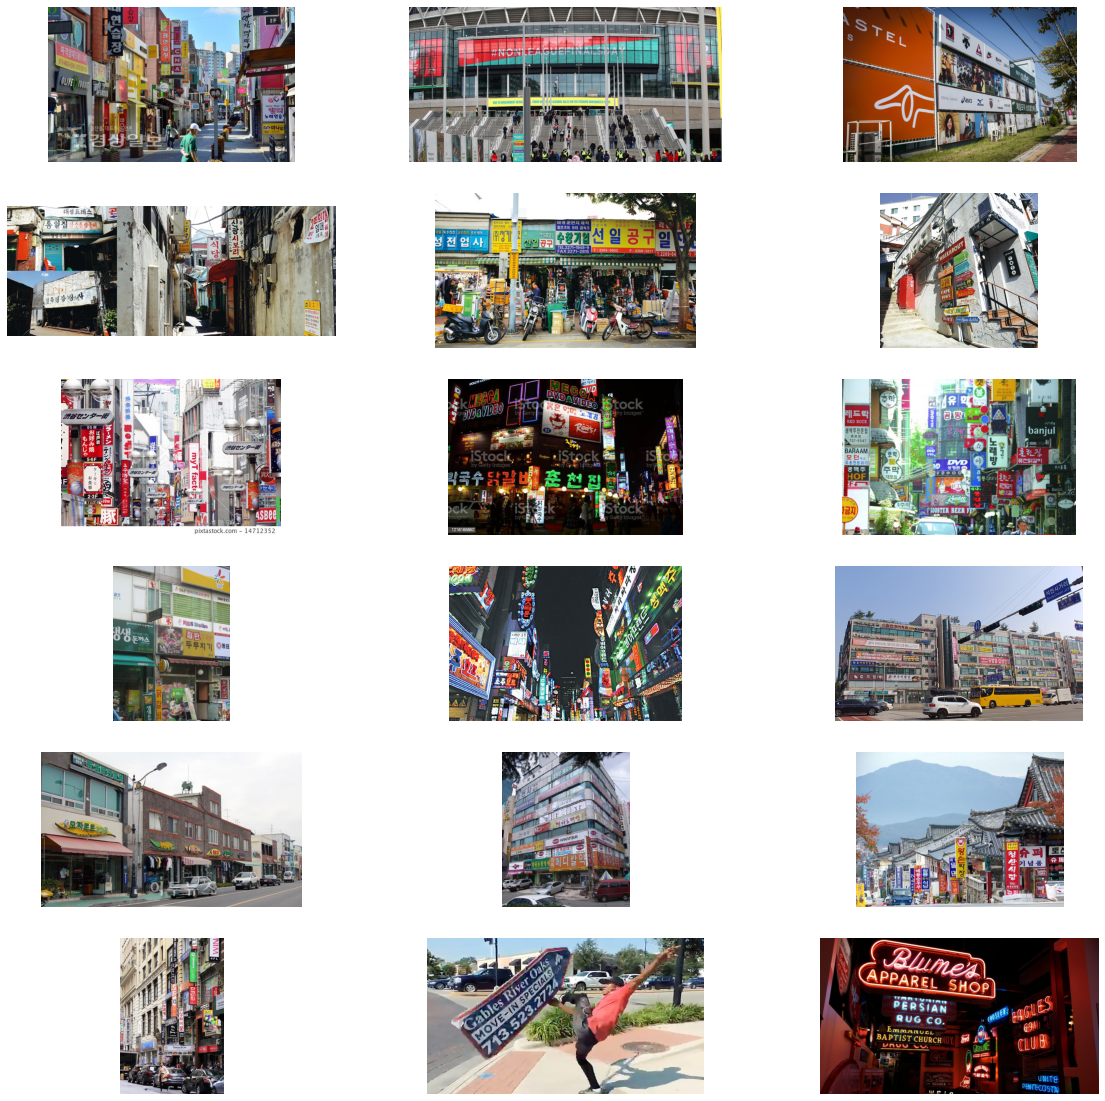

In [17]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

In [18]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [19]:
for im in images:
    detect_text(im)

Texts:

"2F
www.reNE
raphy
OLITE TOUIC
Factoryl
Candy Mi H
노래연습
G 마나보
울산을대표하연론
in
명상일보
才号
ি 80 ব ত
ㅋ 연습장
대 BOBI
"

"2F"

"www.reNE"

"raphy"

"OLITE"

"TOUIC"

"Factoryl"

"Candy"

"Mi"

"H"

"노래"

"연습"

"G"

"마나"

"보"

"울산"

"을"

"대표"

"하연"

"론"

"in"

"명상"

"일보"

"才"

"号"

"ি"

"80"

"ব"

"ত"

"ㅋ"

"연습장"

"대"

"BOBI"
bounds: (169,251),(171,281),(159,282),(157,252)
Texts:

"#NONLE
UEF
DE DOVERNMENT RE
THERE W
ALCONOL SALES ON THE STADUM CONCOURSES T
bigas
"

"#NONLE"

"UEF"

"DE"

"DOVERNMENT"

"RE"

"THERE"

"W"

"ALCONOL"

"SALES"

"ON"

"THE"

"STADUM"

"CONCOURSES"

"T"

"bigas"
bounds: (39,298),(50,298),(50,305),(39,305)
Texts:

"DESCENTE
BLACK YAK
NIKE
ASTEL
le cousportil
EXA
MSUNG
LGE
BEAN POLE
PARKLAND
HEAD
Olivia Lauren dasıcs Y
InocATIS
FUEIU
SAMSU
"

"DESCENTE"

"BLACK"

"YAK"

"NIKE"

"ASTEL"

"le"

"cousportil"

"EXA"

"MSUNG"

"LGE"

"BEAN"

"POLE"

"PARKLAND"

"HEAD"

"Olivia"

"Lauren"

"dasıcs"

"Y"

"InocATIS"

"FUEIU"

"SAMSU"
bounds: (263,1050),(292,1047),(293,1057

UnboundLocalError: local variable 'text' referenced before assignment

In [20]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [21]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


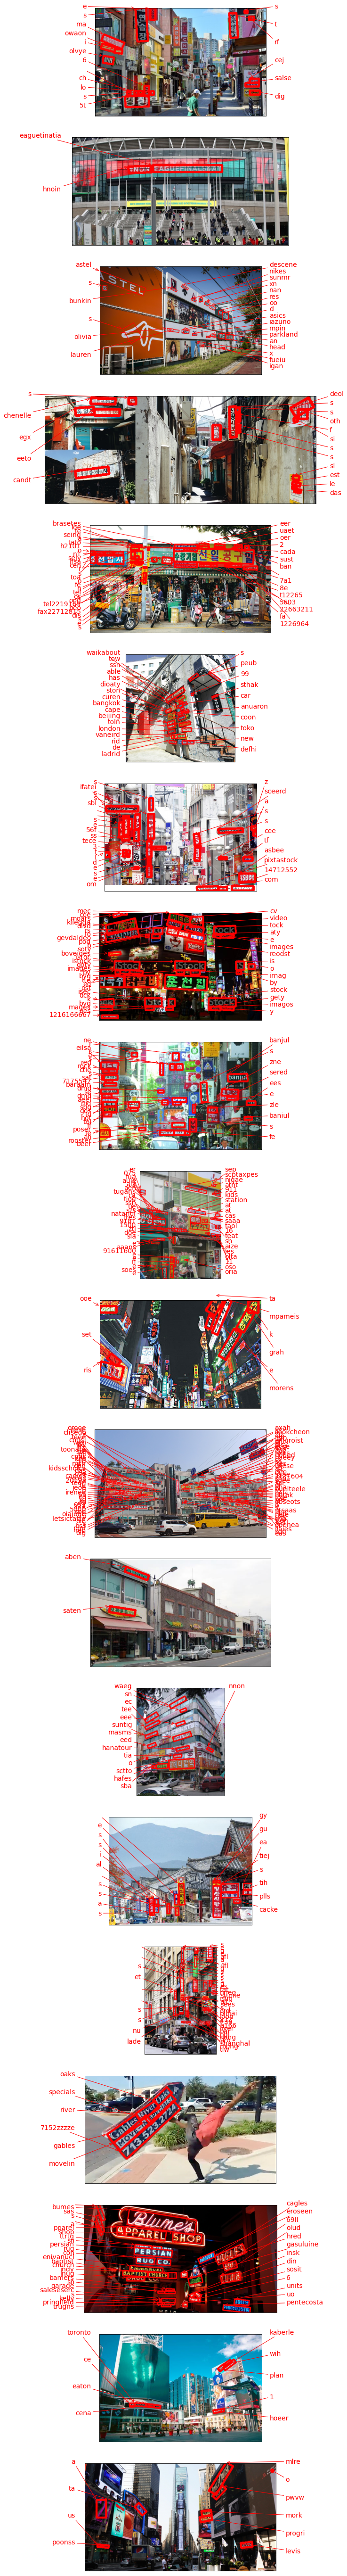

In [22]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [25]:
# 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    # 기본적으로 image_to_data를 씀
    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        # Output을 이용해 Dict형태로 출력
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/q11.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png


In [26]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

    |

Done
